## Assignments

To close out this checkpoint, you'll do two assignments. Both require you to create Jupyter notebooks. Please submit links to your notebooks below

### 1. Predicting temperature

In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of [this dataset from Kaggle](https://www.kaggle.com/budincsevity/szeged-weather). To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

* First, load the dataset from the **weatherinszeged** table from Thinkful's database.
* Build a regression model where the target variable is *temperature*. As explanatory variables, use *humidity*, *windspeed*, *windbearing*, and *pressure*. Estimate the model using OLS.
* Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

Here are the credentials you can use to connect to the database:

```
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'
```

As in earlier assignments, be sure to close the database connection after initially pulling in your data.

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

## Preliminary data exploration

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


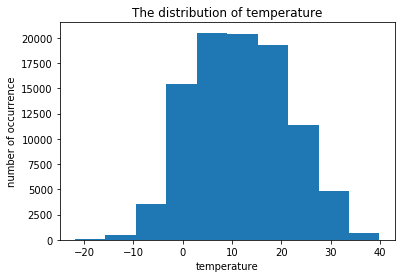

In [3]:
plt.hist(weather_df.temperature)
plt.title("The distribution of temperature")
plt.xlabel("temperature")
plt.ylabel("number of occurrence")
plt.show()

In [4]:
weather_df.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [5]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


In [6]:
weather_df.isnull().sum().sort_values(ascending = False)

dailysummary           0
pressure               0
loudcover              0
visibility             0
windbearing            0
windspeed              0
humidity               0
apparenttemperature    0
temperature            0
preciptype             0
summary                0
date                   0
dtype: int64

In [7]:
# fixing cloudcover column name
weather_df = weather_df.rename({'loudcover': 'cloudcover'}, axis =1)

In [8]:
num_cols = weather_df.select_dtypes(['int64', 'float64']).columns
print(num_cols)

Index(['temperature', 'apparenttemperature', 'humidity', 'windspeed',
       'windbearing', 'visibility', 'cloudcover', 'pressure'],
      dtype='object')


No nulls in the data set.

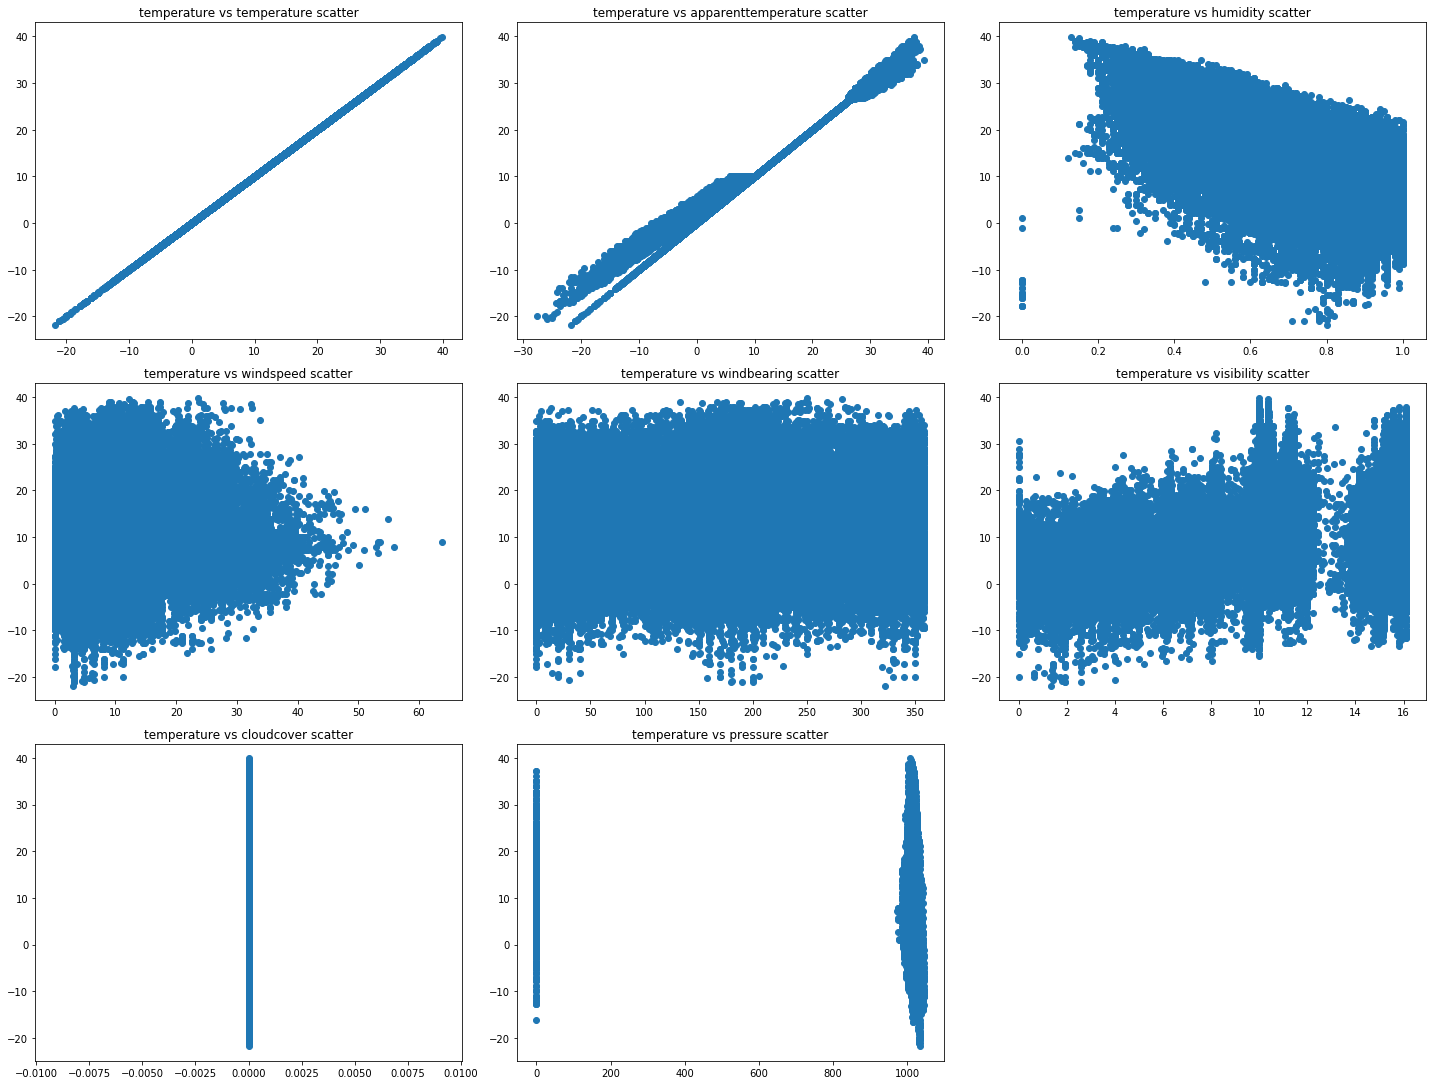

In [9]:
def draw_scatter(df, columns, n_rows, n_cols):
    fig=plt.figure(figsize = (20,40))
    for i, var_name in enumerate(columns):
        ax=fig.add_subplot(n_rows, n_cols, i+1)
        ax.scatter(df[var_name], df['temperature'])
        ax.set_title('temperature vs ' + str(var_name) + " scatter")
    fig.tight_layout()
    plt.show()
    
draw_scatter(weather_df, num_cols, len(num_cols), 3)

## Simple Linear Regression

In [10]:
X = weather_df[['humidity', 'windspeed', 'windbearing', 'pressure']]
Y = weather_df.temperature

lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.92643818528537


In [11]:
x = sm.add_constant(X)

results = sm.OLS(Y, x).fit()

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.750e+04
Date:                Wed, 24 Jun 2020   Prob (F-statistic):               0.00
Time:                        08:00:38   Log-Likelihood:            -3.2821e+05
No. Observations:               96453   AIC:                         6.564e+05
Df Residuals:                   96448   BIC:                         6.565e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9264      0.233    162.709      0.000      37.470      38.383
humidity      -32.4962      0.123   -264.288      0.000     -32.737     -32.255
windspeed      -0.2014      0.003    -57.557      0.000      -0.208      -0.195
windbearing     0.0040      0.000     18.463      0.000       0.004       0.004
pressure       -0.0007      0.000     -3.452      0.001      -0.001      -0.000
==============================================================================
Omnibus:                     3375.432   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3793.297
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       3.339   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Not a strong R-squared...

## Gauss-Markov Condition Checks

### Linearity of the model in its coefficients

Mean of the errors in the medical costs model is: -1.9624955657832385e-15


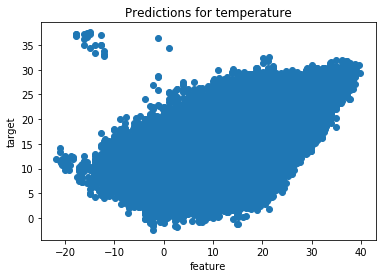

In [12]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

plt.scatter(Y, predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Predictions for temperature')
plt.show()

Mean error seems to be effectively zero. <br>
Not a strong signal for linear relationships, although not completely void of them.

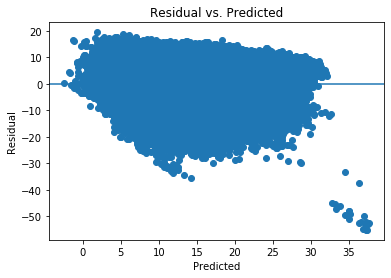

In [13]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [14]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic

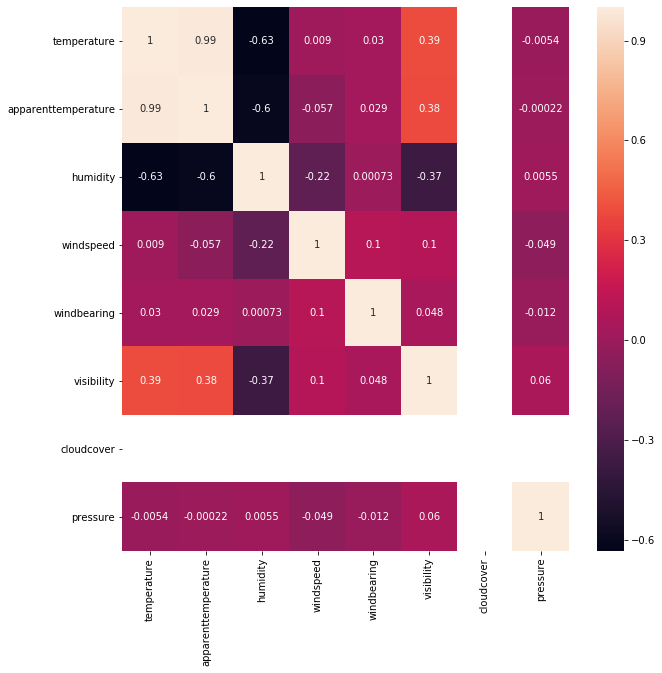

In [15]:
# See the correlation heatmap of the features
plt.figure(figsize=(10,10))
sns.heatmap(weather_df[num_cols].corr(),annot=True)

No apparant sign of multicollinearity.

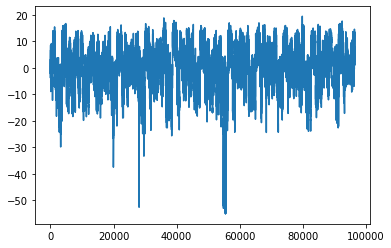

In [16]:
plt.plot(errors)
plt.show()

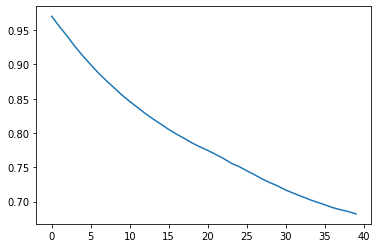

In [17]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

Autocorrelation between the errors of the model appears fairly high. This fails the check for error terms.

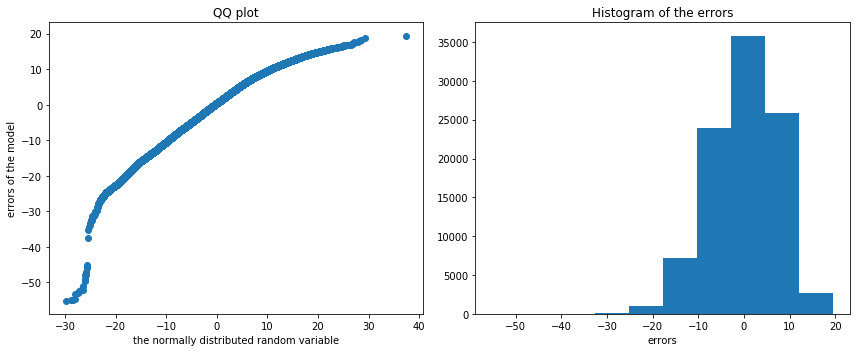

In [18]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [19]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [20]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.296735252356 and p value is 0.0
Normality test statistics is 3375.4323076995797 and p value is 0.0


The p-values of both tests indicate that our errors are not normally distributed.

It appears that the majority of Gauss Markov Condition checks failed to support a linear regression model. 
Perhaps, this data is not best modeled using linear regression. Most likely a good idea to apply different models for prediction in this case.

### 2. House prices

To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database. 
* Reimplement the model you built in the previous checkpoint. 
* Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.
*  be sure to close the database connection after initially pulling in your data.

In [21]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

## Preliminary data exploration

In [25]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df_houseprices = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

df_houseprices.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


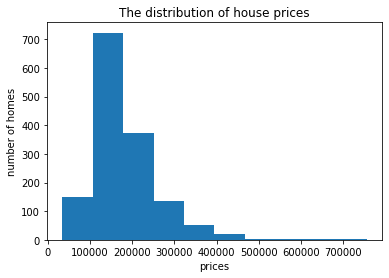

In [26]:
plt.hist(df_houseprices.saleprice)
plt.title("The distribution of house prices")
plt.xlabel("prices")
plt.ylabel("number of homes")
plt.show()

In [27]:
df_houseprices.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [28]:
df_houseprices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [29]:
num_cols = df_houseprices.select_dtypes(['int64', 'float64']).columns
print(num_cols)

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')


In [30]:
non_numeric_columns = df_houseprices.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [31]:
total_nulls = df_houseprices.isnull().sum().sort_values(ascending=False)
percent_nulls = (df_houseprices.isnull().sum()/df_houseprices.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_nulls, percent_nulls], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


In [32]:
np.abs(df_houseprices[num_cols].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

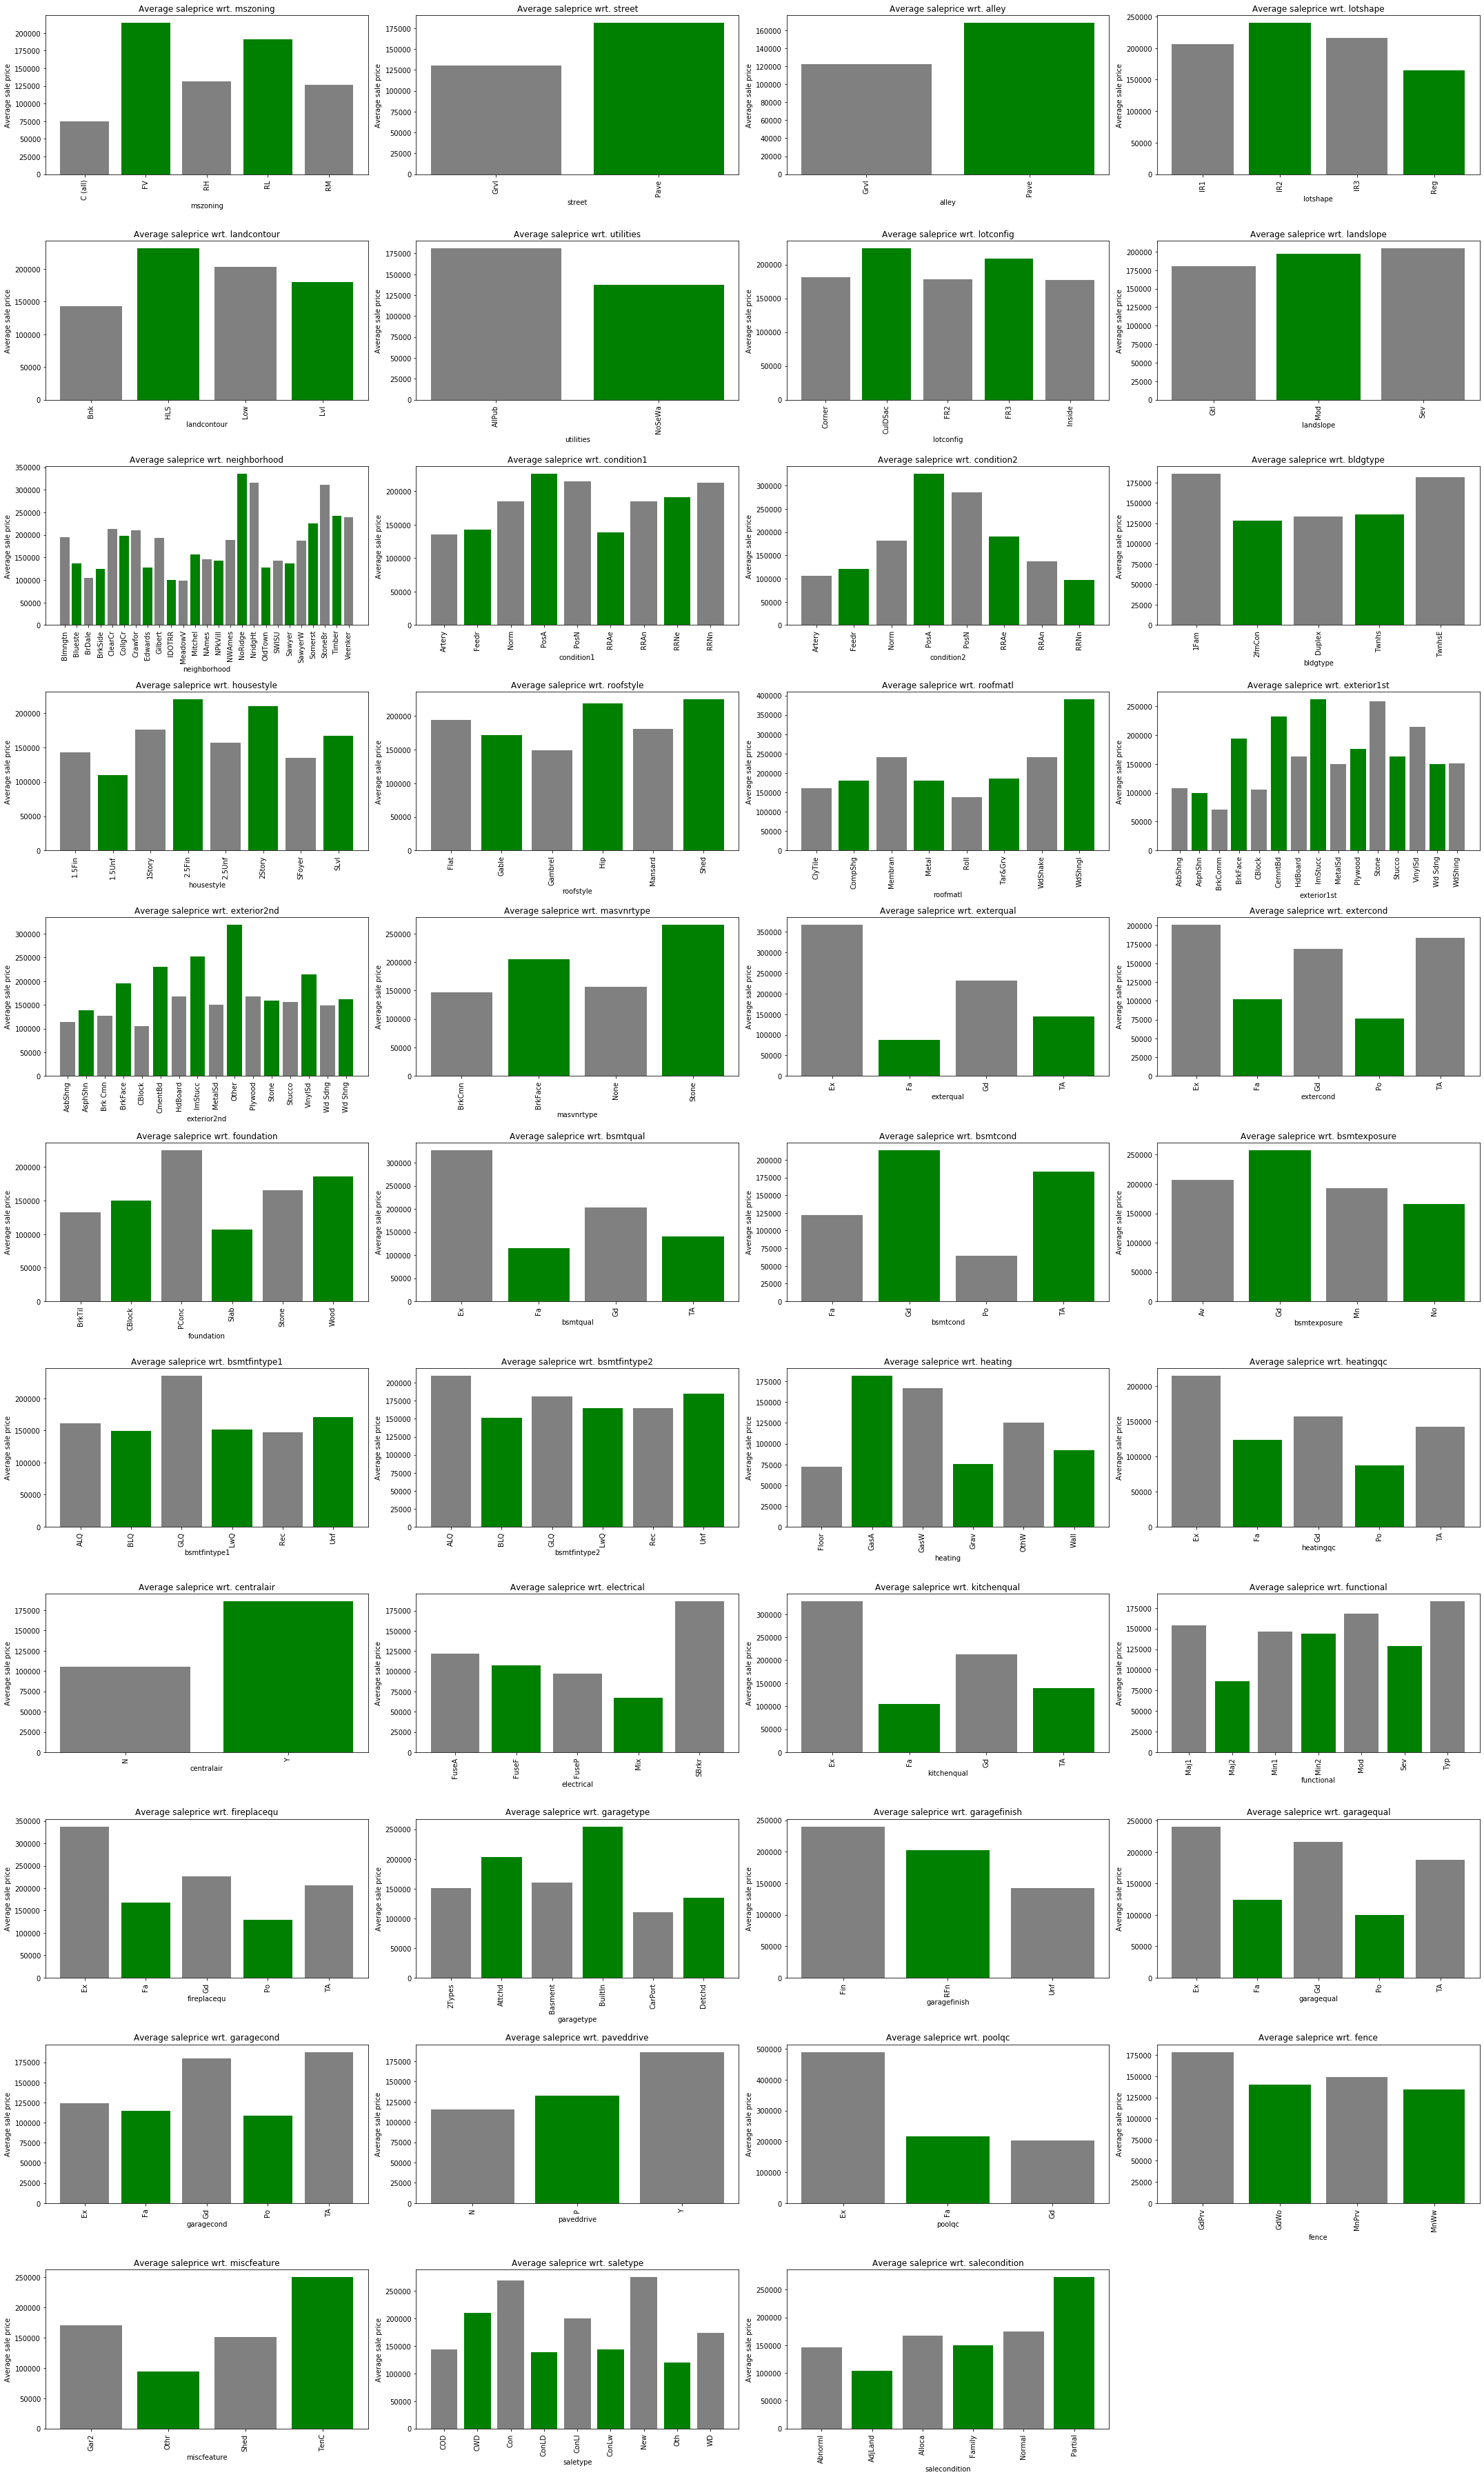

In [33]:
plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(df_houseprices.groupby(column)["saleprice"].mean().index, df_houseprices.groupby(column)["saleprice"].mean(),
           color=("grey","green"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [34]:
df_houseprices = pd.concat([df_houseprices,pd.get_dummies(df_houseprices.mszoning, prefix="mszoning", drop_first=True)], axis=1)
df_houseprices = pd.concat([df_houseprices,pd.get_dummies(df_houseprices.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(df_houseprices.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df_houseprices.street, prefix="street", drop_first=True).columns)

### Simple Linear Regression

In [35]:
X = df_houseprices[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]
Y = df_houseprices.saleprice

In [37]:
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [2.33265353e+04 4.56343565e+01 1.34501364e+04 1.64082048e+01
 2.83816393e+01 2.50875137e+04 1.34204564e+04 2.85658560e+04
 9.04778936e+03 1.51037622e+02]

Intercept: 
 -117337.72871399307


In [36]:
x = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              saleprice   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                              3628.
Date:                Wed, 24 Jun 2020   Prob (F-statistic):                        0.00
Time:                        08:19:10   Log-Likelihood:                         -17496.
No. Observations:                1460   AIC:                                  3.501e+04
Df Residuals:                    1450   BIC:                                  3.506e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
overallqual  2.287e+04   1101.586     20.761      0.000    2.07e+04     2.5e+04
grlivarea      45.5731      2.502     18.212      0.000      40.664      50.482
garagecars   1.425e+04   3030.130      4.704      0.000    8308.345    2.02e+04
garagearea     10.7389     10.512      1.022      0.307      -9.881      31.359
totalbsmtsf    28.1893      2.972      9.485      0.000      22.359      34.019
mszoning_FV -1.077e+04   1.27e+04     -0.847      0.397   -3.57e+04    1.42e+04
mszoning_RH -2.405e+04    1.5e+04     -1.606      0.108   -5.34e+04    5320.366
mszoning_RL -8232.1752   1.16e+04     -0.713      0.476   -3.09e+04    1.44e+04
mszoning_RM -2.873e+04   1.17e+04     -2.462      0.014   -5.16e+04   -5837.863
street_Pave -7.613e+04   1.15e+04     -6.642      0.000   -9.86e+04   -5.37e+04
==============================================================================
Omnibus:                      400.598   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35172.115
Skew:                          -0.014   Prob(JB):                         0.00
Kurtosis:                      27.045   Cond. No.                     5.08e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Mean of the errors in the medical costs model is: -1.6445657621099525e-11


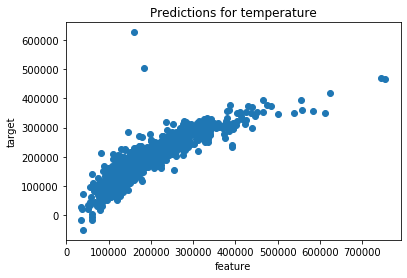

In [38]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

plt.scatter(Y, predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Predictions for temperature')
plt.show()

Mean error seems to be effectively zero. <br>
Fairly strong signal for linear relationships.

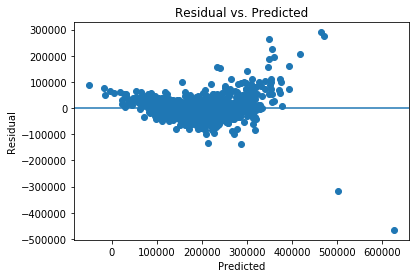

In [39]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [40]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 497.754 and p value is 2.93e-110
Levene test statistic value is 491.982 and p value is 7.29e-101


The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic

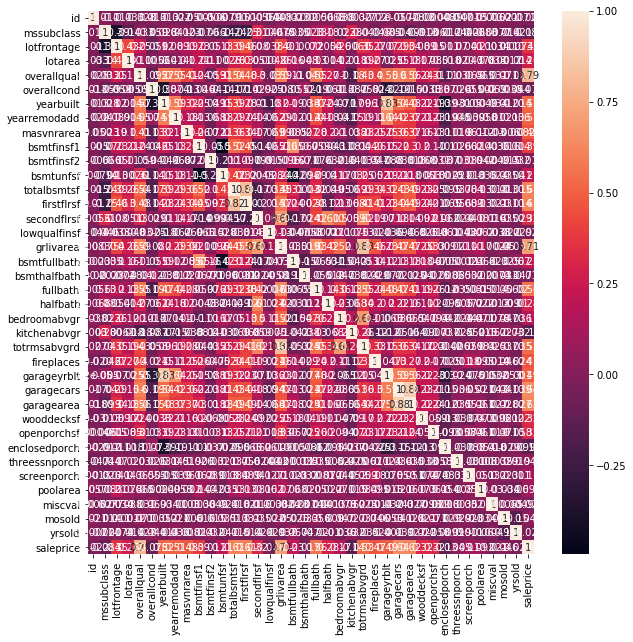

In [42]:
# See the correlation heatmap of the features
plt.figure(figsize=(10,10))
sns.heatmap(df_houseprices[num_cols].corr(),annot=True)

Possible signs of multicollinearity. Best practice would be to remove those variables of concern.

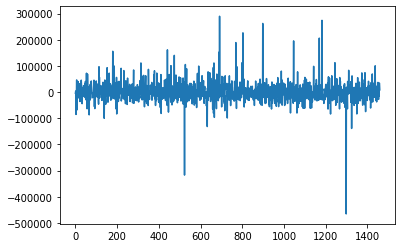

In [43]:
plt.plot(errors)
plt.show()

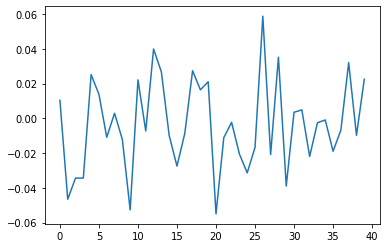

In [44]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

Autocorrelation between the errors of the model appears fairly low. This passes the check for error terms.

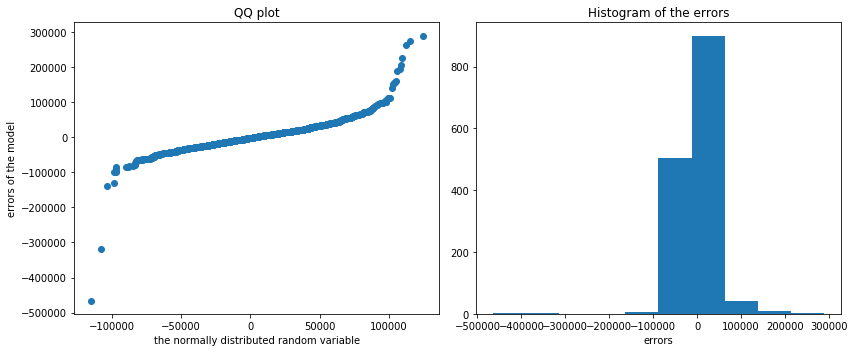

In [45]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [46]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [47]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 41281.526018265205 and p value is 0.0
Normality test statistics is 415.88265685862757 and p value is 4.922984898072417e-91


These graphs demonstrate that the data is not normally normally distributed. However, this could be an issue with lacking outlier analysis. One could predict normality could improve.

Looking back to both models, an argument could be made that with the correct feature engineering and selection methods, linear regression models can predict house prices more successfully than predicting temperature... with this data.